Importing the required libraries:

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# About Dataset

The dataset used for model building contained 10999 observations of 12 variables. The data contains the following information:

* ID: ID Number of Customers.
* Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,F.
* Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
* Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
* Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
* Cost of the product: Cost of the Product in US Dollars.
* Prior purchases: The Number of Prior Purchase.
* Product importance: The company has categorized the product in the various parameter such as low, medium, high.
* Gender: Male and Female.
* Discount offered: Discount offered on that specific product.
* Weight in gms: It is the weight in grams.
* Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

Loading and showing the dataset:

In [76]:
shipping = pd.read_csv('shipping.csv')
shipping.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


Verifying count of strings and columns:

In [77]:
shipping.shape

(10999, 12)

# Data Analysis Purposes

In this case we need to predict product arriving: product will arrive in time or at the wrong time?

# Data Preparation

### 1. Finding missing values

We need to find all missing values to exclude errors in our data analysis. Using a simply method __info()__ to do this:

In [78]:
shipping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


We can see non-null count of cells for every column. These values are equal to each other and equal to string count. There are no missing values.

### 2. Checking the outliers

Looking on numerical summary statistics of our dataset:

In [79]:
shipping.loc[:, 'Warehouse_block':].describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached.on.Time_Y.N,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


Creating a distribution plot for best understanding:

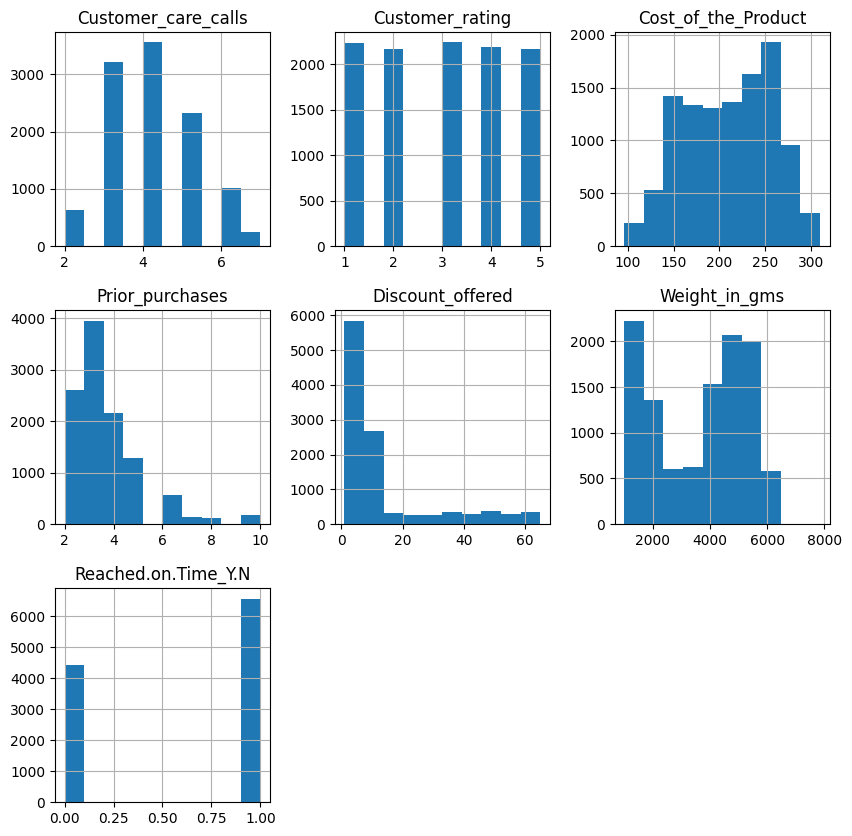

In [80]:
shipping.loc[:, 'Warehouse_block':].hist(figsize=(10, 10));

The distribution shows that there are no outliers in the data.

Now we can work with our data.

# Why is the product was arrived in time or at the wrong time?

To answer this question we need to use machine learning instrument, such as decision tree.

Looking at the data again:

In [81]:
shipping.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


Column "ID" is not important for analysis so we can drop it:

In [82]:
x = shipping.drop(['ID'], axis=1)

We have several columns with a low number of unique values and their data type is object. Transforming these columns into number datatype for using it in analysis:

In [83]:
le = LabelEncoder()
x['Warehouse_block'] = le.fit_transform(x['Warehouse_block'])
x['Mode_of_Shipment'] = le.fit_transform(x['Mode_of_Shipment'])
x['Product_importance'] = le.fit_transform(x['Product_importance'])
x['Gender'] = le.fit_transform(x['Gender'])

In [84]:
x.head(1)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,3,0,4,2,177,3,1,0,44,1233,1


Plotting a correlation matrix of our features:

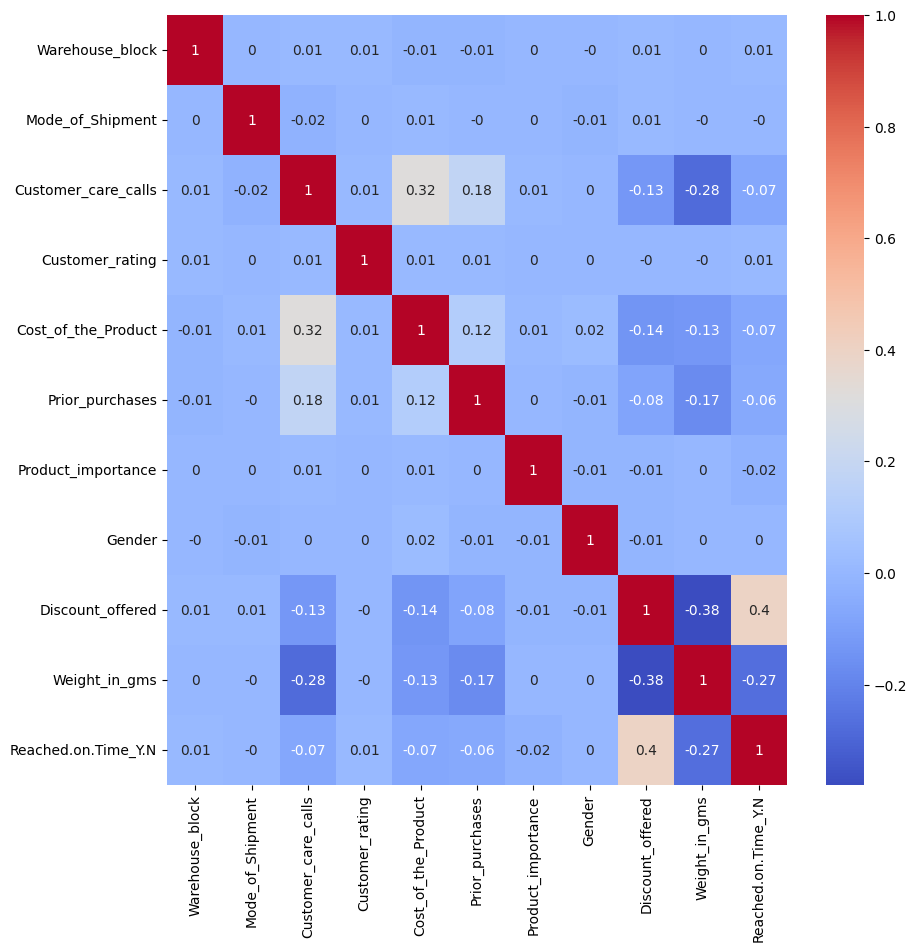

In [85]:
plt.figure(figsize=(10, 10))
sns.heatmap(round(x.corr(), 2), annot=True, cmap='coolwarm');

Selecting most important features where correlation coefficient >= 0.05:

In [86]:
x = x[['Customer_care_calls', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']]
y = shipping['Reached.on.Time_Y.N']

In [87]:
x.head()

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
0,4,177,3,44,1233
1,4,216,2,59,3088
2,2,183,4,48,3374
3,3,176,4,10,1177
4,2,184,3,46,2484


Splitting our data to training and testing parts:

In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

Creating a classifier:

In [89]:
rf = RandomForestClassifier(random_state=40)

Setting parameters for searching the best estimator:

In [90]:
parameters = {'n_estimators': range(5, 51, 10),
              'max_depth': range(1, 12, 2),
              'min_samples_leaf': range(1, 8),
              'min_samples_split': range(2, 9, 2)}

Creating example of a class "GridSearchCV" for searching the best estimator:

In [91]:
grid_search = GridSearchCV(estimator=rf, param_grid=parameters, cv=5, n_jobs=-1)

Fitting the example by loading training data:

In [92]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=40), n_jobs=-1,
             param_grid={'max_depth': range(1, 12, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 9, 2),
                         'n_estimators': range(5, 51, 10)})

Showing the best estimator:

In [93]:
best_clf = grid_search.best_estimator_

Plotting the feature importance pie chart:

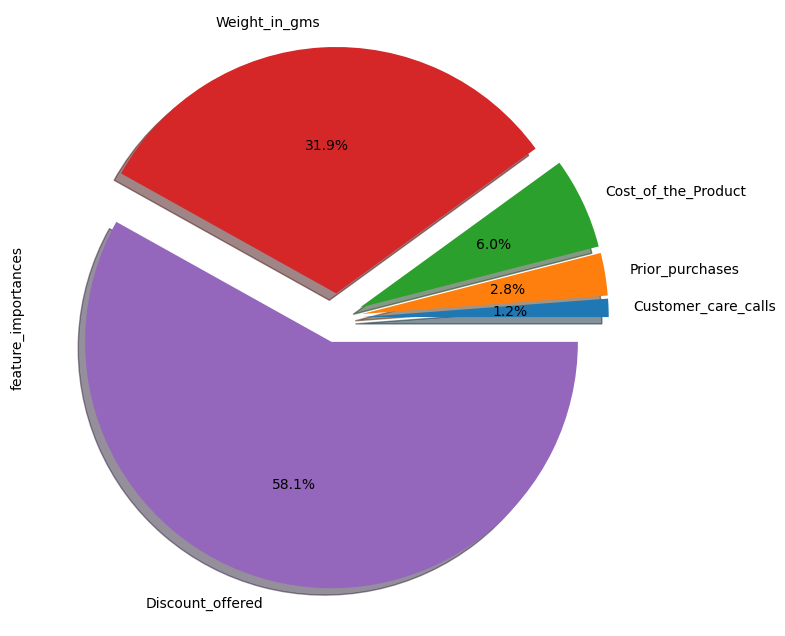

In [94]:
feature_importances_df = pd.DataFrame({'features': list(x_train.columns),
                                       'feature_importances': best_clf.feature_importances_})\
                                        .sort_values(by='feature_importances')
feature_importances_df.plot.pie(
                                explode=[0.1] * len(x_train.columns),
                                labels=feature_importances_df.features,
                                y='feature_importances',
                                autopct='%1.1f%%',
                                shadow=True,
                                legend=False,
                                figsize=(8, 8));

Finding predictions on testing data:

In [95]:
predictions = best_clf.predict(x_test)

Calculating ML metrics for our model:

In [96]:
score = best_clf.score(x_test, y_test)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

In [97]:
score, accuracy, recall, precision, f1

(0.6884297520661157,
 0.6884297520661157,
 0.5299345182413471,
 0.8999205718824463,
 0.6670591698557551)

Plotting the confusion matrix:

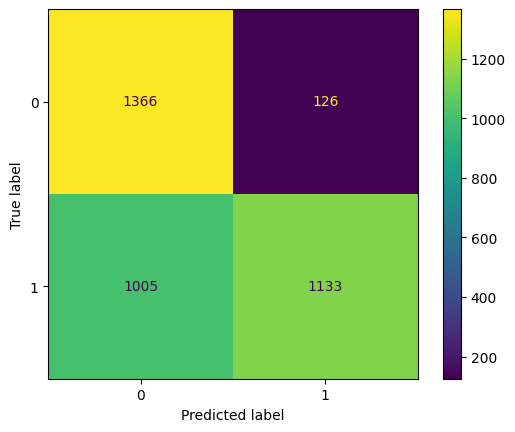

In [98]:
conf_m = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_m, display_labels=best_clf.classes_)
disp.plot();

# Conclusion

We see that most important features are __weight__, __discount__, __cost__, __prior purchases__ and __customer care calls__. __Weight__ and __discount__ influence on the target variable is greater than another features.